In [1]:
import os
import numpy as np
import pandas as pd
import pickle, itertools
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

from utils_prediction.database import gbq_connect, gbq_query
con = gbq_connect()

Google Big Query Connection Established


<Figure size 432x288 with 0 Axes>

#### Path vars

In [30]:
results_fpath = "/hpf/projects/lsung/projects/mimic4ds/artifacts"
us_fpath = "side_exp_results/underspecification"
groups = ['2008 - 2010', '2011 - 2013', '2014 - 2016', '2017 - 2019']
tasks = ['mortality','longlos']
metrics = ['auc','auprc']

analysis_tag = "baseline"
train_group = '2008 - 2010'

In [25]:
task_names = {
    'mortality':'Mortality',
    'longlos':'Long LOS'
}
model_names = {
    'lr':'Logistic\nRegression',
    'rf':'Random\nForest',
    'xgb':'XGBoost',
    'nn':'Neural\nNetwork'
    }
ylims = {
    'auc':{
        "alias":'AUROC',
        "mortality":[0.7, 0.95],
        "longlos":[0.6,0.85]
    },
    'auprc':{
        "alias":'AUPRC',
        "mortality":[0.3, 0.6],
        "longlos":[0.5,0.65]
    }
}

##### Underspecification check - variability in performance

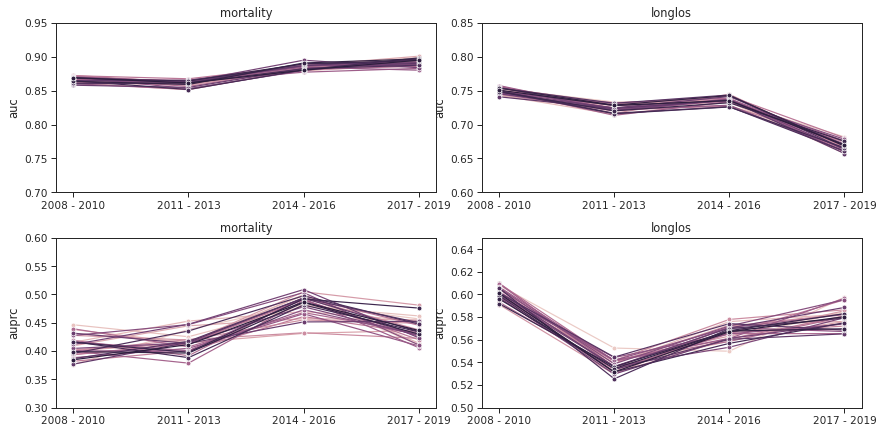

In [103]:
df_results = pd.DataFrame(dtype = float)
c=0
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(12,6))
plt.tight_layout(h_pad = 2)
for m,metric in enumerate(metrics):
    for t,task in enumerate(tasks):
        idf = pd.DataFrame(dtype = float)
        for i in range(30):
            fpath = f"{results_fpath}/analysis_id={task}/{us_fpath}/{train_group}_{i}"
            for group in groups:
                c+=1
                df = pd.read_csv(f"{fpath}/{group}.csv")
                df['iter'] = i
                df['eval'] = group
                df['task'] = task
                idf = pd.concat((idf,df),axis=0)
        
        # outlier removal
        idf = idf.query("metric == @metric and task == @task")
        perf_mean = idf.groupby('eval')['performance'].mean()
        perf_std = idf.groupby('eval')['performance'].std()
        lower_lim = perf_mean - 3*perf_std
        upper_lim = perf_mean + 3*perf_std
        idf = idf.join(lower_lim,on='eval',rsuffix='_lower').join(upper_lim,on='eval',rsuffix='_upper')
        idf = idf.query("performance>performance_lower and performance<performance_upper")
        
        # combine
        df_results = pd.concat((df_results, idf),axis=0)
        
        # plot
        sns.lineplot(
            data = df_results.query("metric==@metric and task==@task"),
            x = 'eval',
            y = 'performance',
            hue = 'iter',
            marker = 'o',
            ax = axes[m][t],
            legend=False
        )
        axes[m][t].set_ylim(ylims[metric][task])
        axes[m][t].set_title(f"{task}")
        axes[m][t].set_ylabel(f"{metric}")
        axes[m][t].set_xlabel('')

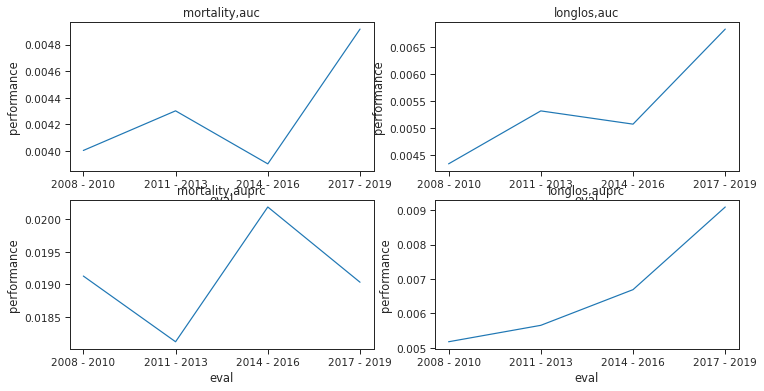

In [100]:
std_results = pd.DataFrame(
    columns = ['task','metric','2008 - 2010','2011 - 2013','2014 - 2016', '2017 - 2019'],
    dtype=float
)
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(12,6))
c = 0
for m,metric in enumerate(metrics):
    for t,task in enumerate(tasks):
        c+=1
        idf = df_results.query("metric==@metric and task==@task")
        #std_results.loc[c,:] = [task,metric]+idf.groupby('eval')['performance'].std().values.tolist()

        sns.lineplot(
            data = pd.DataFrame(idf.groupby('eval')['performance'].std()).reset_index(),
            x = 'eval',
            y = 'performance',
            ax = axes[m][t]
        )
        axes[m][t].set_title(f"{task},{metric}")

#### Feature Importance agreement among random seeds

In [109]:
def jaccard(list1, list2):
    """
    assumes unique values in each list
    J(list1,list2) = |intersection(list1, list2)| / |union(list1, list2)|
    """
    intersection = len(set(list1).intersection(set(list2)))
    union = len(set(list1).union(set(list2)))
    return float(intersection) / float(union)

def get_top(df,n):
    return df.mean().sort_values(ascending=False).index.values[:n].tolist()

top_n = int(0.2 * len(fi.results.columns))

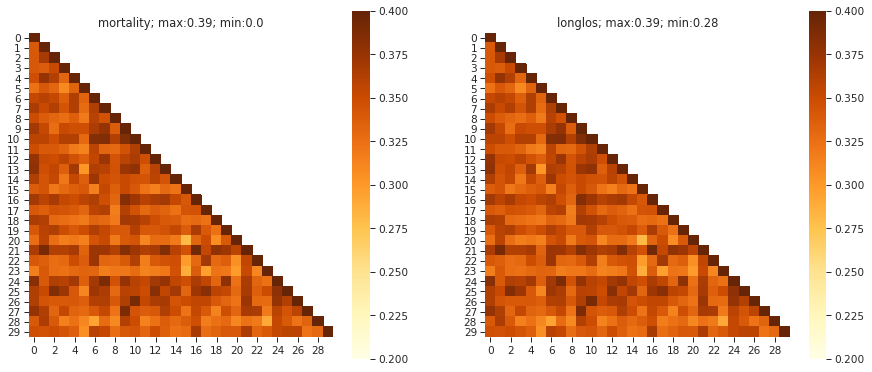

In [113]:
jaccard_score = np.zeros(shape=(30,30))

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
c=0
for i,analysis_id in enumerate(['mortality','longlos']):
    for j in itertools.combinations(range(30),2):
        c+=1
        fpath = f"{results_fpath}/analysis_id={task}/{us_fpath}"
        fname0 = f"{train_group}_{j[0]}/feature_importance.pkl"
        fname1 = f"{train_group}_{j[1]}/feature_importance.pkl"
        f0 = open(f"{fpath}/{fname0}","rb")
        fi0 = pickle.load(f0)
        f1 = open(f"{fpath}/{fname1}","rb")
        fi1 = pickle.load(f1)
        jaccard_score[j[0],j[1]] = jaccard(get_top(fi0.results,top_n), get_top(fi1.results,top_n))
    np.fill_diagonal(jaccard_score,1)
    jaccard_score = np.rot90(np.fliplr(jaccard_score))
    mask = np.triu(np.ones_like(jaccard_score, dtype=bool),k=1)
    sns.heatmap(
        jaccard_score,
        vmin=0.2,
        vmax=0.4,
        square = True,
        #annot = True,
        cmap = 'YlOrBr',
        ax = axes[i],
        mask = mask,
        cbar_kws={"shrink":.8}
    )
    axes[i].set_title(
        f"{analysis_id}; max:{round(np.max(jaccard_score[jaccard_score<1]),2)}; min:{round(np.min(jaccard_score[jaccard_score<1]),2)}"
    )

In [111]:
import time
topn = int(len(fi.results.columns)*0.2)
common_features = {}
concept_types = ['lab','icucharts','proc','presc','diag']
dem_concepts = ["age","marital","ethnicity","insurance","language"]
for analysis_id in tasks:
    topns = []
    for i in range(30):
        # load feature importance results
        fpath = f"{results_fpath}/analysis_id={analysis_id}/{us_fpath}"
        fname = f"{train_group}_{i}/feature_importance.pkl"
        f = open(f"{fpath}/{fname}","rb")
        fi = pickle.load(f)
        # grab top N features
        topns.append(fi.results.mean().sort_values(ascending=False).index.values.tolist()[:topn])
    
    # obtain common features
    common_features[analysis_id] = set(topns[0])
    for s in topns[1:]:
        common_features[analysis_id].intersection_update(s)
    
    ## group features by concept type
    # static / demographic
    print(f"\n\ntask: {analysis_id}")
    features_dem = []
    for x in common_features[analysis_id]:
        for j in dem_concepts:
            if j in x: features_dem.append(x)
    if features_dem: print(f"static: {features_dem}")
    
    id_list = []
    for concept in concept_types:
        id_list = [x.split('_')[0] for x in common_features[analysis_id] if concept in x]
        if len(id_list)>0:
            if concept == 'lab':
                q = f"select label from `mimic-iv-ches.hosp.d_labitems` where itemid in {tuple([int(x) for x in id_list])}"
            elif concept == 'icucharts': 
                q = f"select abbreviation from `mimic-iv-ches.icu.d_items` where itemid in {tuple([int(x) for x in id_list])}"
            elif concept == 'presc':
                if len(id_list) == 1:
                    q = f"select ndc, drug from `mimic-iv-ches.hosp.prescriptions` where ndc = '{id_list[0]}'"
                else:
                    q = f"select ndc, drug from `mimic-iv-ches.hosp.prescriptions` where ndc in {tuple(id_list)}"
            elif concept == 'diag':
                q = f"select long_title from `mimic-iv-ches.hosp.d_icd_diagnoses` where icd_code in {tuple(id_list)}"
            elif concept == 'proc':
                q = f"select long_title from `mimic-iv-ches.hosp.d_icd_procedures` where icd_code in {tuple(id_list)}"
            df = gbq_query(con,q,verbose=False)
            time.sleep(1)
            if concept != 'presc':
                print(f"{concept}: {np.squeeze(df.values).tolist()}")
            else:
                print(f"{concept}: {df.groupby('ndc').first()['drug'].values.tolist()}")



task: mortality
static: ['marital', 'age']
lab: ['pH', 'Vitamin B12', 'Lactate Dehydrogenase (LD)', 'Albumin', 'Alkaline Phosphatase', 'Myelocytes', 'RDW', 'RBC']
icucharts: ['Motor Response', 'Verbal Response', 'Riker-SAS Scale', 'Braden Nutrition', 'Braden Sensory Perception', 'Braden Mobility', 'Mental status', 'Secondary diagnosis', 'Arterial Base Excess', 'PO2 (Venous)', 'PH (Venous)', 'NBP Alarm - High', 'RR', 'FiO2', 'O2 Flow', 'SpO2', 'NBPm', 'HR', 'Temperature F', '22 Gauge placed in outside facility', 'Family Meeting']
presc: ['Morphine Sulfate', 'Propofol', 'Propofol']


task: longlos
lab: ['Osmolality, Measured', 'Alkaline Phosphatase', 'Chloride']
icucharts: ['Braden Mobility', 'Chloride (serum)', 'ICP Alarm - Low', 'RR', 'Inspired Gas Temp.', 'ABPm', 'HR', 'Temperature F', 'Subglottal Suctioning', 'Special diet', 'ICP Line Zero/Calibrate', 'ICP Line Dressing Occlusive', 'IABP Zero/Calibrate', 'IABP placed in outside facility', 'IABP Alarms Activated', 'ICP Line placed i